##### 经过手动调整df，即删除不必要的行，如行2012-2013Q1，将df变为数据集data


In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import nsdiffs, ndiffs
from pmdarima import auto_arima
import os

In [2]:
file_path = r"C:\Users\huawei\OneDrive\桌面\data.xlsx"

# 读取数据，time列解析为日期但不设为索引
df1 = pd.read_excel(file_path, parse_dates=['time'])

# 按时间列从小到大排序
df1 = df1.sort_values('time').reset_index(drop=True)

print(df1.dtypes)
print(f"\n数据形状：{df1.shape}")

time                      datetime64[ns]
ln_gdp_sa                        float64
ln_gdp_seasonal_factor           float64
dln_gdp_sa                       float64
city_mean_light                  float64
region_mean_light                float64
ln_city                          float64
ln_region                        float64
GDP                              float64
ln_gdp                           float64
pc1                              float64
pc2                              float64
pc3                              float64
dpc2                             float64
quarter                            int64
dln_city                         float64
dln_region                       float64
dtype: object

数据形状：(64, 17)


In [ ]:
# 计算df1中主要变量的统计性描述 - 表格格式
import pandas as pd
import numpy as np

# 定义要分析的变量及其英文名称
variables_info = {
    'GDP': 'GDP (Yuan billions)',
    'city_mean_light': 'Shenzhen City Average Light Value', 
    'region_mean_light': 'Guangdong Province Average Light Value',
    'pc1': 'Principal Component 1',
    'pc2': 'Principal Component 2', 
    'pc3': 'Principal Component 3'
}

# 计算总观测数（使用所有变量都有数据的行数）
available_vars = [var for var in variables_info.keys() if var in df1.columns]
if available_vars:
    complete_data = df1[available_vars].dropna()
    total_n = len(complete_data)
else:
    total_n = len(df1)

print("Descriptive Statistics of Variables")
print("="*50)
print(f"Characteristic\tN = {total_n}")
print("="*50)

for var, var_name in variables_info.items():
    if var in df1.columns:
        data = df1[var].dropna()
        
        # 计算统计量
        mean_val = data.mean()
        median_val = data.median()
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        sd_val = data.std()
        min_val = data.min()
        max_val = data.max()
        
        # 格式化数值 - 根据数值大小选择合适的格式
        if abs(mean_val) >= 1000:
            mean_str = f"{mean_val:,.0f}"
            median_str = f"{median_val:,.0f}"
            q1_str = f"{q1:,.0f}"
            q3_str = f"{q3:,.0f}"
            sd_str = f"{sd_val:,.0f}"
            min_str = f"{min_val:,.0f}"
            max_str = f"{max_val:,.0f}"
        elif abs(mean_val) >= 1:
            mean_str = f"{mean_val:.2f}"
            median_str = f"{median_val:.2f}"
            q1_str = f"{q1:.2f}"
            q3_str = f"{q3:.2f}"
            sd_str = f"{sd_val:.2f}"
            min_str = f"{min_val:.2f}"
            max_str = f"{max_val:.2f}"
        else:
            mean_str = f"{mean_val:.4f}"
            median_str = f"{median_val:.4f}"
            q1_str = f"{q1:.4f}"
            q3_str = f"{q3:.4f}"
            sd_str = f"{sd_val:.4f}"
            min_str = f"{min_val:.4f}"
            max_str = f"{max_val:.4f}"
        
        # 打印统计信息
        print(f"{var_name}")
        print(f"    Mean\t{mean_str}")
        print(f"    Median(Q1/Q3)\t{median_str}({q1_str}/{q3_str})")
        print(f"    SD\t{sd_str}")
        print(f"    Min / Max\t{min_str} / {max_str}")
        
    else:
        print(f"{var_name}")
        print("    Data not available")
    
    print()  # 空行分隔

print("="*50)
print("Source: Data from Excel file 'data.xlsx'")
print("Note: Statistics calculated from available observations.")
print("Missing values are excluded from calculations.")
print("All variables are quarterly data.")

=== 主要变量的统计性描述（简化版）===

              变量名  观测值        均值    25%分位数       中位数    75%分位数       标准差      偏度      峰度       最小值        最大值
              GDP   64 5406.8398 3230.0125 5184.6450 7459.3750 2482.8472  0.1454 -1.0511 1634.6500 10867.5900
  city_mean_light   64   17.1011   14.5502   15.6861   19.9836    3.4115  0.7260 -0.8418   12.5532    23.9568
region_mean_light   64    1.8368    1.3796    1.6867    2.3433    0.6106  0.4165 -1.0729    0.9530     3.0145
              pc1   64   -0.0081   -0.3007   -0.0030    0.3257    0.5021 -0.1128  0.1824   -1.3010     1.0589
              pc2   64   -0.0126   -0.1591   -0.0839    0.0444    0.1988  1.2100  0.3325   -0.2351     0.5059
              pc3   64    0.0014   -0.0568   -0.0092    0.0365    0.1106  0.3060  3.4488   -0.3947     0.3137

统计指标说明：
- 观测值：有效数据点数量（去除缺失值）
- 均值：算术平均数
- 25%分位数：第一四分位数，25%的数据小于此值
- 中位数：第二四分位数，50%的数据小于此值
- 75%分位数：第三四分位数，75%的数据小于此值
- 标准差：数据的离散程度
- 偏度：分布的不对称性（>0右偏，<0左偏，=0对称）
- 峰度：分布的尖峰程度（>0尖峰，<0平峰）
- 最小值和最大值：数据的极值


In [3]:
# 去掉df最后5行
df = df1[:-5]
print(f"删除后数据形状：{df.shape}")

删除后数据形状：(59, 17)


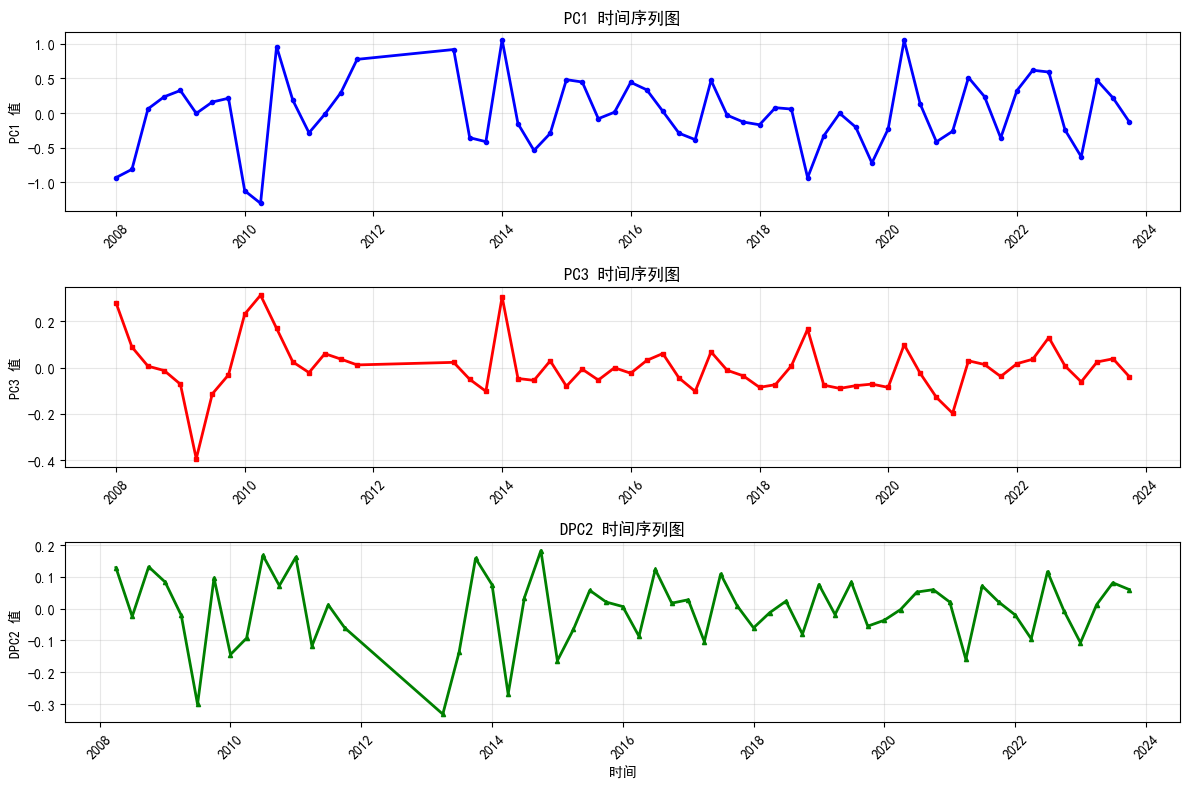

In [4]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 创建子图
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# 绘制三个变量的折线图
variables = ['pc1', 'pc3', 'dpc2']
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']

for i, (var, color, marker) in enumerate(zip(variables, colors, markers)):
    axes[i].plot(df['time'], df[var], linewidth=2, color=color, marker=marker, markersize=3)
    axes[i].set_title(f'{var.upper()} 时间序列图', fontsize=12)
    axes[i].set_ylabel(f'{var.upper()} 值')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

axes[-1].set_xlabel('时间')
plt.tight_layout()
plt.show()

In [5]:
var1 = ['dln_gdp_sa', 'dln_city', 'dln_region', 'pc1', 'pc3', 'dpc2']
for var1 in var1:
    mean_val = df[var1].mean()
    std_val = df[var1].std()
    min_val = df[var1].min()
    max_val = df[var1].max()
    threshold = mean_val + 3 * std_val
    
    # 检查异常值
    outliers = df[df[var1] > threshold]
    
    print(f"\n{var1.upper()}:")
    print(f"  均值: {mean_val:.4f}")
    print(f"  标准差: {std_val:.4f}")
    print(f"  最小值: {min_val:.4f}")
    print(f"  最大值: {max_val:.4f}")
    print(f"  异常值阈值 (均值+3σ): {threshold:.4f}")
    
    if len(outliers) > 0:
        print(f"  发现 {len(outliers)} 个异常值:")
        for idx, row in outliers.iterrows():
            print(f"    时间: {row['time']}, 值: {row[var1]:.4f}")
    else:
        print(f"  未发现异常值")


DLN_GDP_SA:
  均值: 0.0244
  标准差: 0.0540
  最小值: -0.1816
  最大值: 0.1482
  异常值阈值 (均值+3σ): 0.1864
  未发现异常值

DLN_CITY:
  均值: 0.0124
  标准差: 0.1121
  最小值: -0.5235
  最大值: 0.4759
  异常值阈值 (均值+3σ): 0.3487
  发现 1 个异常值:
    时间: 2022-10-01 00:00:00, 值: 0.4759

DLN_REGION:
  均值: 0.0191
  标准差: 0.0981
  最小值: -0.4312
  最大值: 0.3915
  异常值阈值 (均值+3σ): 0.3135
  发现 1 个异常值:
    时间: 2022-10-01 00:00:00, 值: 0.3915

PC1:
  均值: -0.0000
  标准差: 0.5142
  最小值: -1.3010
  最大值: 1.0589
  异常值阈值 (均值+3σ): 1.5425
  未发现异常值

PC3:
  均值: -0.0000
  标准差: 0.1148
  最小值: -0.3947
  最大值: 0.3137
  异常值阈值 (均值+3σ): 0.3444
  未发现异常值

DPC2:
  均值: -0.0036
  标准差: 0.1113
  最小值: -0.3318
  最大值: 0.1828
  异常值阈值 (均值+3σ): 0.3304
  未发现异常值


Pearson Correlation Matrix:
            dln_gdp_sa     pc1     pc3    dpc2  dln_city  dln_region
dln_gdp_sa      1.0000 -0.1747 -0.0571  0.0480    0.0705      0.0708
pc1            -0.1747  1.0000 -0.0000 -0.0306   -0.0959     -0.2485
pc3            -0.0571 -0.0000  1.0000  0.0214   -0.0761     -0.0785
dpc2            0.0480 -0.0306  0.0214  1.0000   -0.1184     -0.1553
dln_city        0.0705 -0.0959 -0.0761 -0.1184    1.0000      0.9000
dln_region      0.0708 -0.2485 -0.0785 -0.1553    0.9000      1.0000

Spearman Correlation Matrix:
            dln_gdp_sa     pc1     pc3    dpc2  dln_city  dln_region
dln_gdp_sa      1.0000 -0.2144  0.0026  0.0075    0.0898      0.1537
pc1            -0.2144  1.0000  0.2816 -0.0608    0.0313     -0.1697
pc3             0.0026  0.2816  1.0000  0.0229    0.1243     -0.0225
dpc2            0.0075 -0.0608  0.0229  1.0000   -0.0974     -0.1137
dln_city        0.0898  0.0313  0.1243 -0.0974    1.0000      0.7817
dln_region      0.1537 -0.1697 -0.0225 -0.113

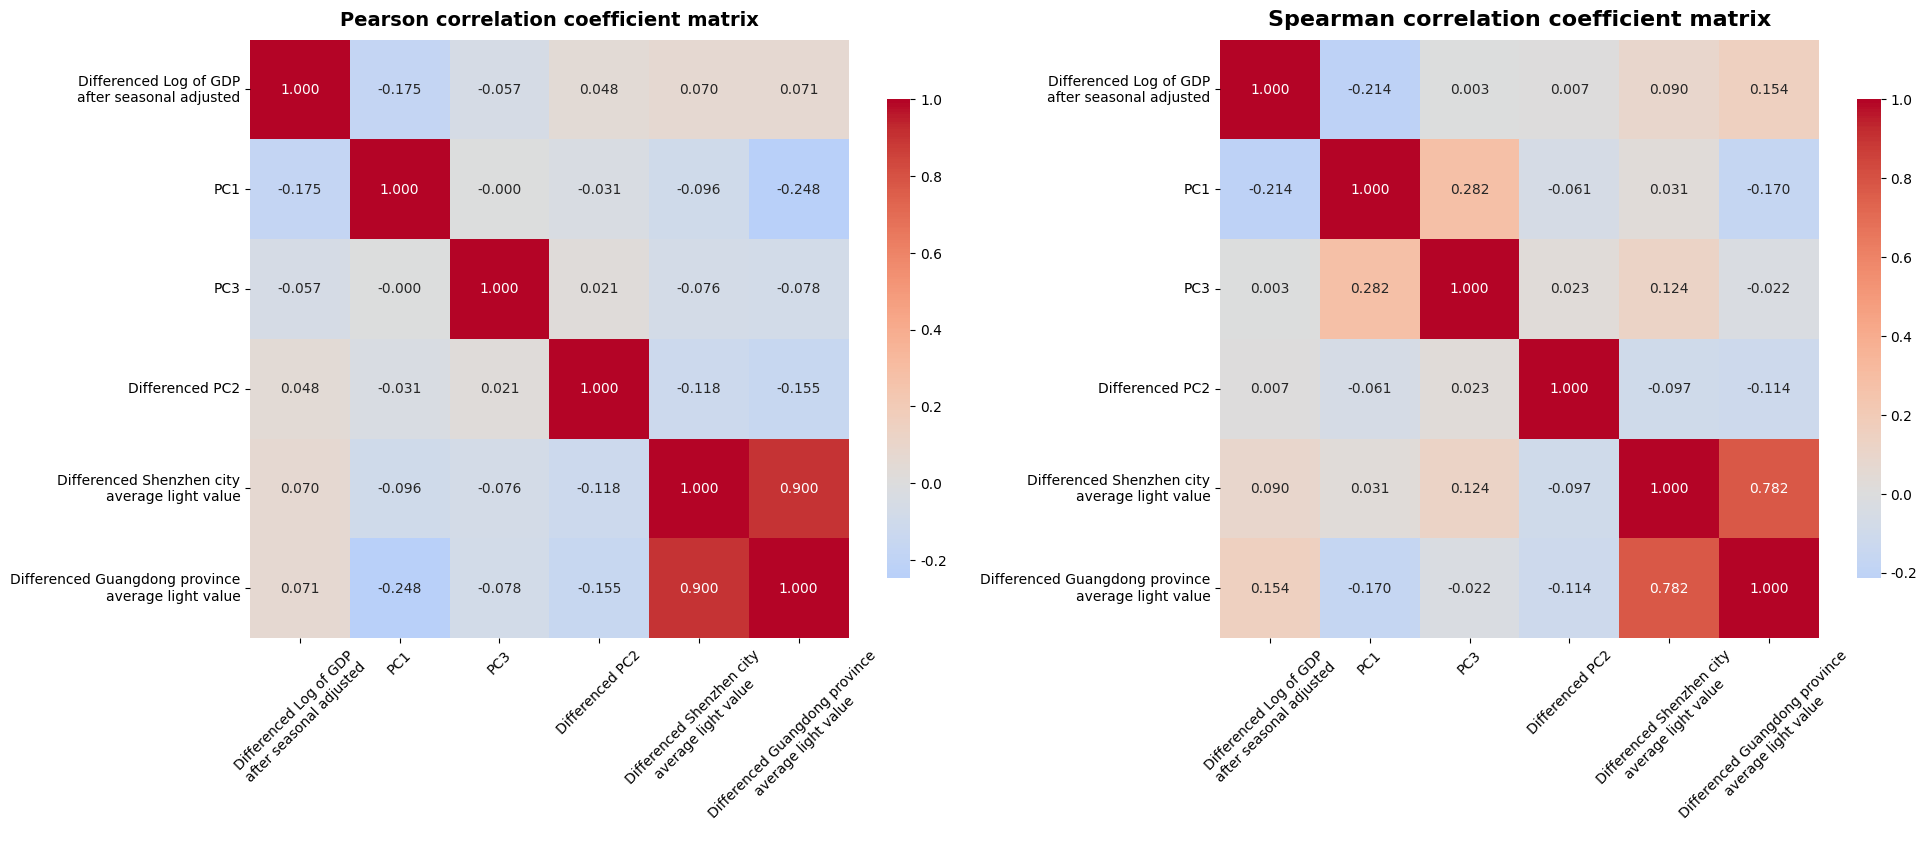

In [12]:
# 选择要分析的变量
variables = ['dln_gdp_sa', 'pc1', 'pc3', 'dpc2', 'dln_city', 'dln_region']

# 提取相关变量的数据
data_corr = df[variables]

# 计算皮尔逊相关系数
pearson_corr = data_corr.corr(method='pearson')
print("Pearson Correlation Matrix:")
print(pearson_corr.round(4))

# 计算斯皮尔曼相关系数
spearman_corr = data_corr.corr(method='spearman')
print("\nSpearman Correlation Matrix:")
print(spearman_corr.round(4))

# 创建英文变量名映射
variable_names_en = {
    'dln_gdp_sa': 'Differenced Log of GDP\nafter seasonal adjusted',
    'pc1': 'PC1',
    'pc3': 'PC3', 
    'dpc2': 'Differenced PC2',
    'dln_city': 'Differenced Shenzhen city\naverage light value',
    'dln_region': 'Differenced Guangdong province\naverage light value'
}

# 重命名相关系数矩阵的索引和列名
pearson_corr_en = pearson_corr.copy()
spearman_corr_en = spearman_corr.copy()

pearson_corr_en.index = [variable_names_en[var] for var in pearson_corr_en.index]
pearson_corr_en.columns = [variable_names_en[var] for var in pearson_corr_en.columns]

spearman_corr_en.index = [variable_names_en[var] for var in spearman_corr_en.index]
spearman_corr_en.columns = [variable_names_en[var] for var in spearman_corr_en.columns]

# 设置字体为支持英文的字体
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 皮尔逊相关系数热力图
sns.heatmap(pearson_corr_en, annot=True, cmap='coolwarm', center=0, ax=ax1, 
            fmt='.3f', square=True, cbar_kws={'shrink': 0.8})
ax1.set_title('Pearson correlation coefficient matrix', fontsize=14, fontweight='bold', pad=10)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y', rotation=0, labelsize=10)

# 斯皮尔曼相关系数热力图
sns.heatmap(spearman_corr_en, annot=True, cmap='coolwarm', center=0, ax=ax2,
            fmt='.3f', square=True, cbar_kws={'shrink': 0.8})
ax2.set_title('Spearman correlation coefficient matrix', fontsize=16, fontweight='bold', pad=10)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.tick_params(axis='y', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

## 相关性分析结果解读

### 主要发现：

1. **强相关关系**：
   - `dln_city` 与 `dln_region` 相关性最强（皮尔逊0.91，斯皮尔曼0.84）
   - 符合经济理论：城市化进程与区域发展高度相关

2. **弱相关关系**：
   - 其他变量间相关性普遍较低（|r| < 0.3）
   - 说明变量间相对独立，这有利于回归分析时避免多重共线性

3. **斯皮尔曼相关系数相对较高**：
   - 表明变量间可能存在非线性单调关系
   - 在时间序列分析中，这提示我们可能需要考虑非线性转换或滞后效应

4. **对建模的启示**：
   - `dln_city` 和 `dln_region` 可能存在多重共线性，建模时需要注意
   - 其他变量相关性较低，适合作为独立的解释变量


皮尔逊相关系数：测量线性关系的强度

斯皮尔曼相关系数：测量单调关系的强度--不一定是线性


皮尔逊：对异常值敏感，一个极端值可能显著影响相关系数

斯皮尔曼：基于排序，对异常值更稳健


皮尔逊：假设数据服从正态分布

斯皮尔曼：不依赖于特定的数据分布

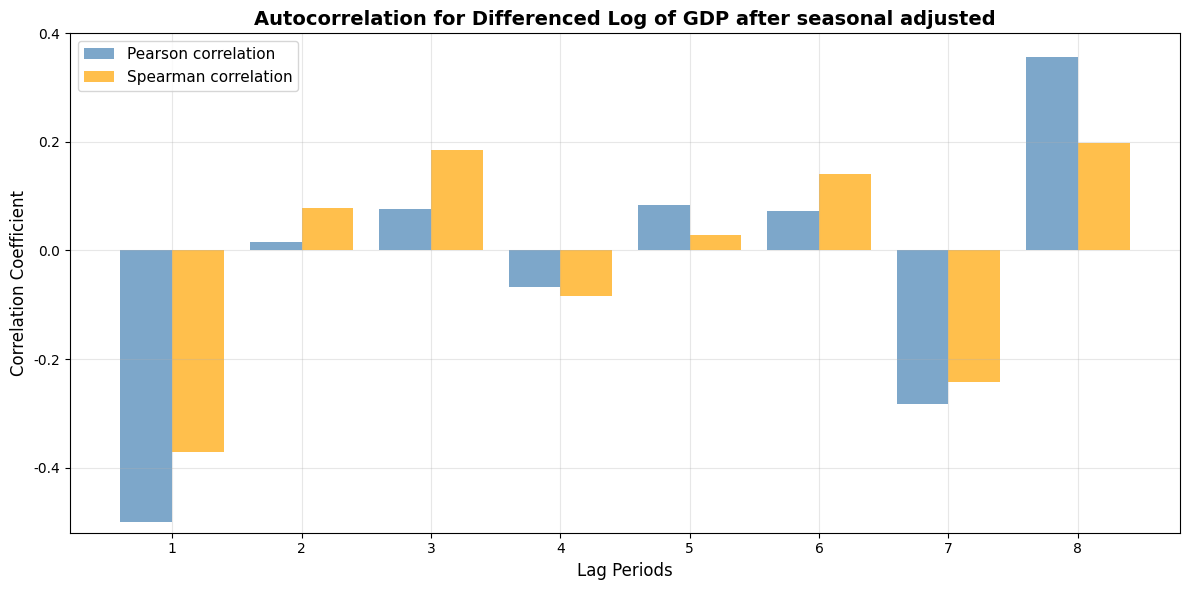

In [15]:
# Autocorrelation analysis for Differenced Log of GDP after seasonal adjusted (Pearson vs Spearman)
lags = range(1, 9)
pearson_auto = [df['dln_gdp_sa'].corr(df['dln_gdp_sa'].shift(lag)) for lag in lags]
spearman_auto = [df['dln_gdp_sa'].corr(df['dln_gdp_sa'].shift(lag), method='spearman') for lag in lags]

# Set English font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
plt.bar([x-0.2 for x in lags], pearson_auto, width=0.4, label='Pearson correlation', alpha=0.7, color='steelblue')
plt.bar([x+0.2 for x in lags], spearman_auto, width=0.4, label='Spearman correlation', alpha=0.7, color='orange')
plt.xlabel('Lag Periods', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Autocorrelation for Differenced Log of GDP after seasonal adjusted', fontsize=14, fontweight='bold')
plt.ylim(-0.52, 0.4)  # Unified scale
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

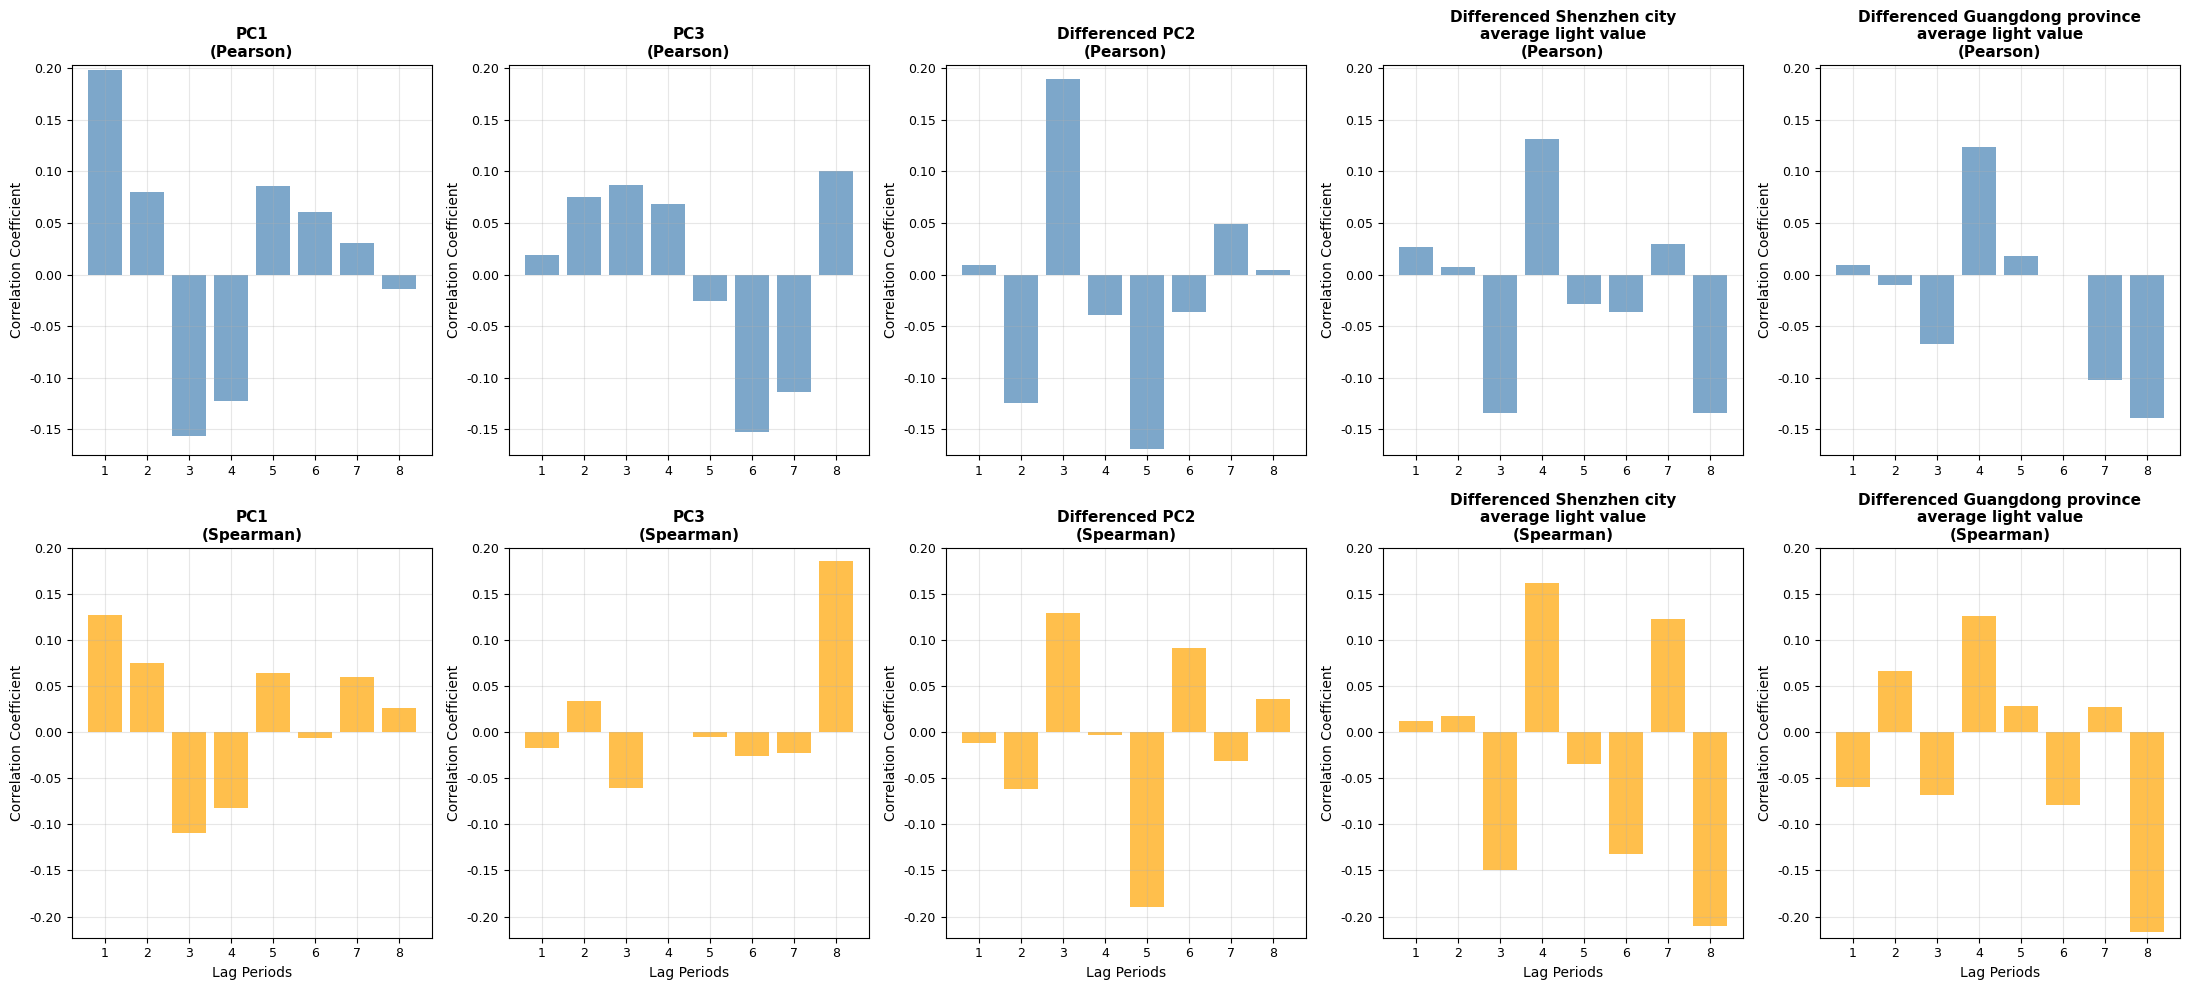

In [36]:
# Lag correlation analysis (quarterly data, analyzing 1-8 period lags)
target_var = 'dln_gdp_sa'
exog_vars = ['pc1', 'pc3', 'dpc2', 'dln_city', 'dln_region']
max_lags = 8

# Variable name mapping for English display
var_names_en = {
    'pc1': 'PC1',
    'pc3': 'PC3', 
    'dpc2': 'Differenced PC2',
    'dln_city': 'Differenced Shenzhen city\naverage light value',
    'dln_region': 'Differenced Guangdong province\naverage light value'
}
target_name_en = 'Differenced Log of GDP\nafter seasonal adjusted'

# Calculate Pearson lag correlations
lag_correlations = {}
for var in exog_vars:
    correlations = []
    for lag in range(1, max_lags + 1):
        corr = df[var].shift(lag).corr(df[target_var])
        correlations.append(corr)
    lag_correlations[var] = correlations

# Calculate Spearman lag correlations
lag_correlations_spearman = {}
for var in exog_vars:
    correlations = []
    for lag in range(1, max_lags + 1):
        corr = df[var].shift(lag).corr(df[target_var], method='spearman')
        correlations.append(corr)
    lag_correlations_spearman[var] = correlations

# Set English font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Comparison visualization (Pearson vs Spearman)
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
for i, var in enumerate(exog_vars):
    var_display_name = var_names_en[var]
    
    # Pearson correlation coefficients
    axes[0, i].bar(range(1, max_lags + 1), lag_correlations[var], alpha=0.7, color='steelblue')
    axes[0, i].set_title(f'{var_display_name}\n(Pearson)', fontsize=11, fontweight='bold')
    axes[0, i].set_ylabel('Correlation Coefficient', fontsize=10)
    axes[0, i].set_ylim(-0.175, 0.203)  # Unified scale
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].tick_params(labelsize=9)
    
    # Spearman correlation coefficients
    axes[1, i].bar(range(1, max_lags + 1), lag_correlations_spearman[var], alpha=0.7, color='orange')
    axes[1, i].set_title(f'{var_display_name}\n(Spearman)', fontsize=11, fontweight='bold')
    axes[1, i].set_xlabel('Lag Periods', fontsize=10)
    axes[1, i].set_ylabel('Correlation Coefficient', fontsize=10)
    axes[1, i].set_ylim(-0.223, 0.2)  # Unified scale
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].tick_params(labelsize=9)

plt.tight_layout()
plt.show()

pc3可能用了一些对经济影响较慢的特征；
强线性关系时，皮尔逊系数会比斯皮尔曼系数高，如在PCs的表现上

## CCF 交叉相关函数

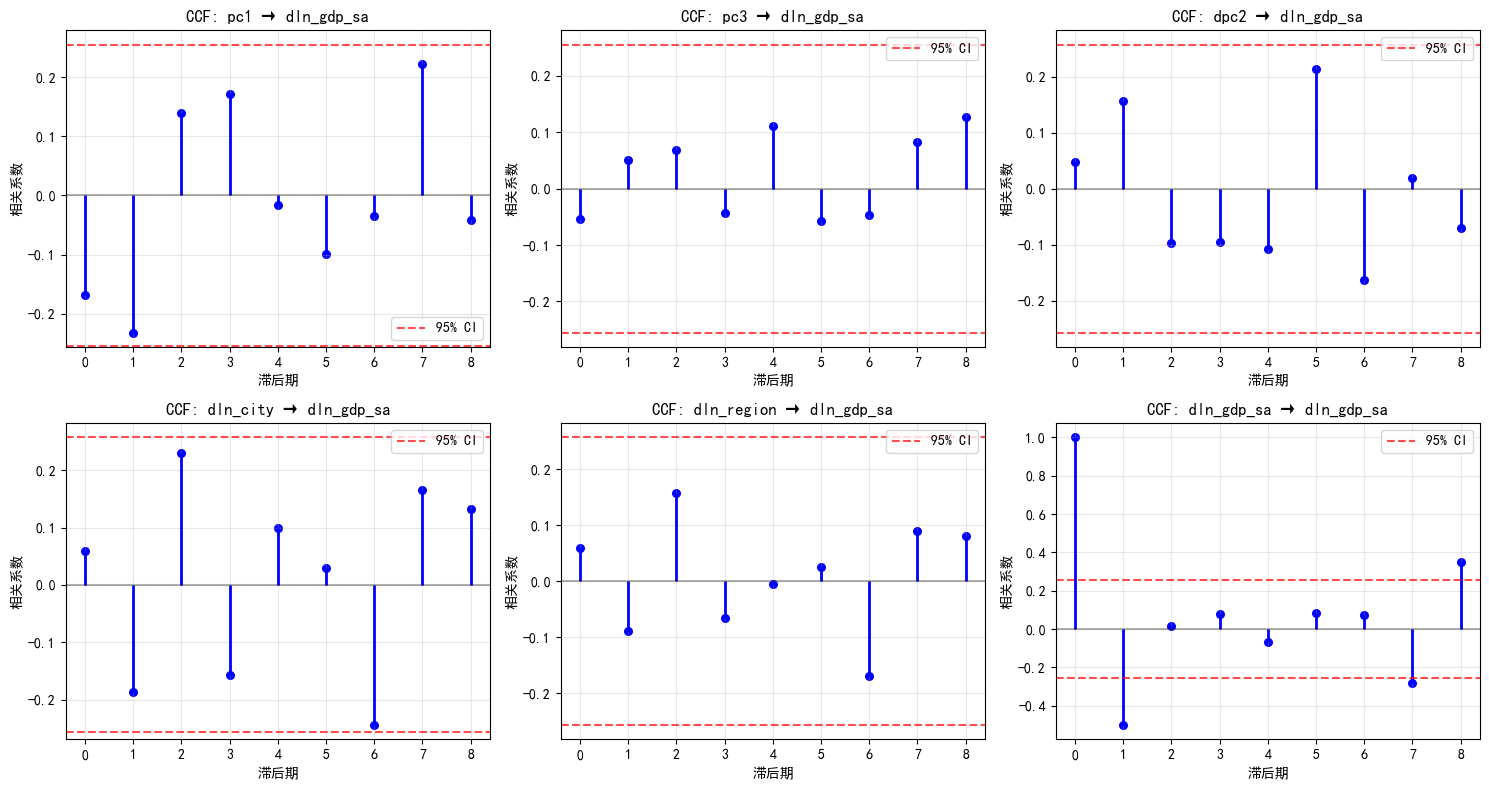

In [11]:
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import numpy as np

# 变量定义
target_var = 'dln_gdp_sa'
exog_vars = ['pc1', 'pc3', 'dpc2', 'dln_city', 'dln_region']
all_vars = exog_vars + [target_var]  # 包含自相关

# 创建子图
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# 计算并绘制CCF
for i, var in enumerate(all_vars):
    ccf_values = ccf(df[var].dropna(), df[target_var].dropna(), adjusted=False)[:9]  # 0到8滞后
    lags = range(9)
    
    # 绘制竖线图（类似ACF/PACF）
    axes[i].vlines(lags, 0, ccf_values, colors='blue', linewidth=2)
    axes[i].scatter(lags, ccf_values, color='blue', s=30)
    axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    # 95%置信区间 (±1.96/√n)
    n = len(df[var].dropna())
    ci = 1.96 / np.sqrt(n)
    axes[i].axhline(y=ci, color='r', linestyle='--', alpha=0.7, label='95% CI')
    axes[i].axhline(y=-ci, color='r', linestyle='--', alpha=0.7)
    axes[i].set_title(f'CCF: {var} → {target_var}')
    axes[i].set_xlabel('滞后期'); axes[i].set_ylabel('相关系数')
    axes[i].grid(True, alpha=0.3); axes[i].legend()

plt.tight_layout(); plt.show()


### ACF/PACF

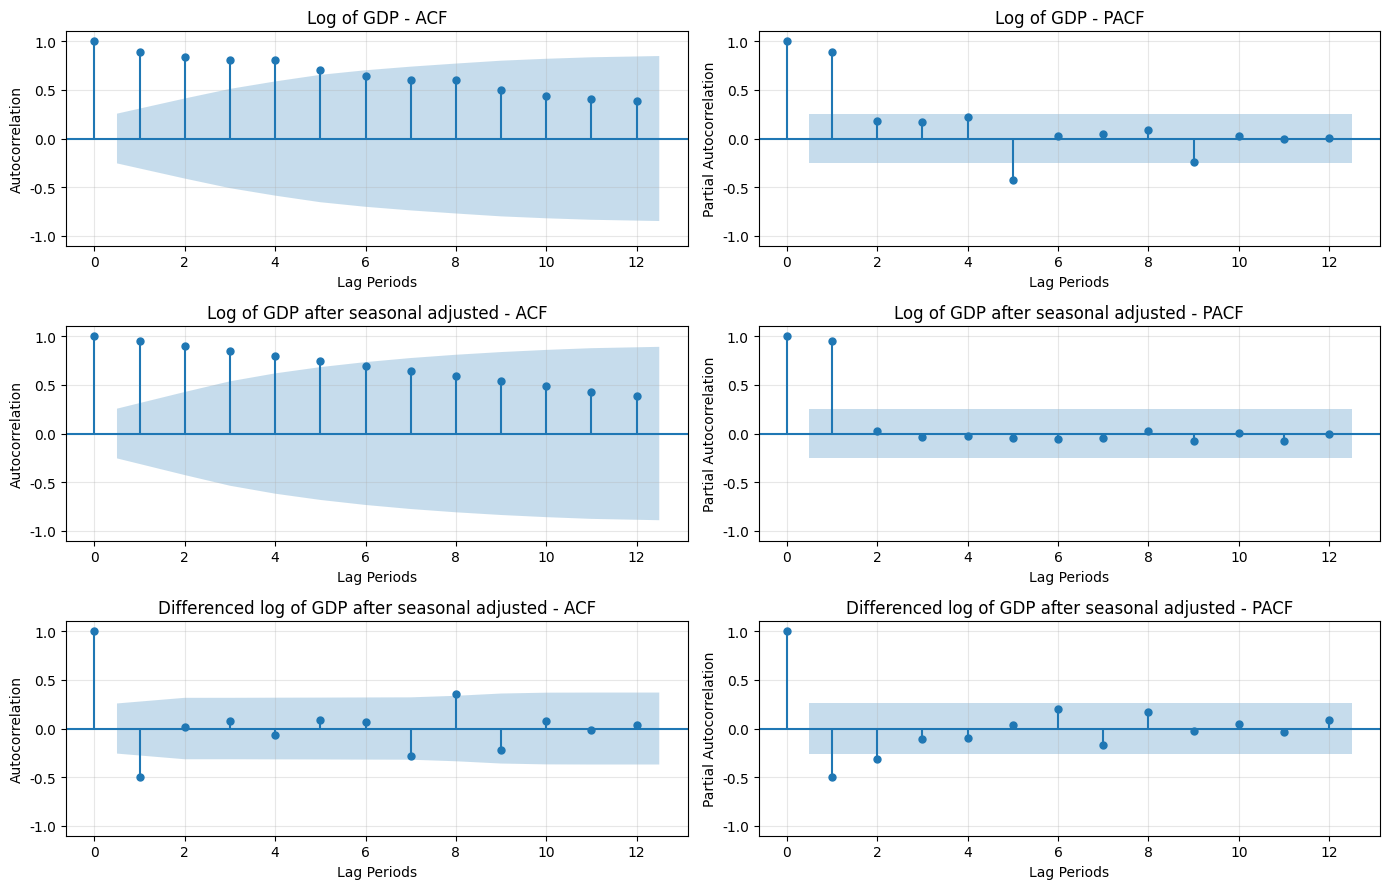

In [40]:
# ACF and PACF Analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Select variables for analysis
variables = ['ln_gdp', 'ln_gdp_sa', 'dln_gdp_sa']

# Variable name mapping for English display
var_names_acf = {
    'ln_gdp': 'Log of GDP',
    'ln_gdp_sa': 'Log of GDP after seasonal adjusted',
    'dln_gdp_sa': 'Differenced log of GDP after seasonal adjusted'
}

# Set English font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Create subplots
fig, axes = plt.subplots(len(variables), 2, figsize=(14, 3*len(variables)))

# Plot ACF and PACF for each variable
for i, var in enumerate(variables):
    var_display_name = var_names_acf[var]
    
    # ACF
    plot_acf(df[var].dropna(), ax=axes[i, 0], lags=12, title=f'{var_display_name} - ACF')
    axes[i, 0].set_ylim(-1.1, 1.1)  # Adjust ACF y-axis range
    axes[i, 0].set_xlabel('Lag Periods')
    axes[i, 0].set_ylabel('Autocorrelation')
    axes[i, 0].grid(True, alpha=0.3)
    
    # PACF
    plot_pacf(df[var].dropna(), ax=axes[i, 1], lags=12, title=f'{var_display_name} - PACF')
    axes[i, 1].set_ylim(-1.1, 1.1)  # Adjust PACF y-axis range
    axes[i, 1].set_xlabel('Lag Periods')
    axes[i, 1].set_ylabel('Partial Autocorrelation')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**PACF vs 自相关系数的差异解释：**

1. **PACF显示AR(3)**：在控制了lag1、lag2后，其他滞后期的直接影响不显著
2. **自相关系数lag7、lag8高**：这是通过AR(2)过程的间接传导效应产生的

**可能的数据生成过程：**
- 短期：AR(3)动态 
- 长期：通过AR(3)的累积效应传导到lag7、lag8
- 季节性：lag8(2年)可能反映商业周期等长期经济模式

**建模启示：**
- 考虑AR(3)作为基础模型
- 可能需要加入季节性成分处理lag8的周期性
- 或考虑ARMA模型捕捉更复杂的动态结构

序列存在显著的自相关结构；ACF的lag1显著：说明相邻期间存在正相关，lag8显著：可能存在某种周期性模式如商业周期；lag1、lag2显著：暗示可能是AR(2)模型的特征

# 模型估计

多选几个变量，让模型做真实预测时可以看看少量数据模型训练出的模型表现怎么样

In [6]:
# 简单ARIMAX前向逐步选择模型
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 1. 数据准备
target = 'dln_gdp_sa'
base_vars = ['pc1', 'pc3', 'dpc2', 'dln_city', 'dln_region']
max_lag = 4

# 创建滞后变量
data = df.copy()
candidates = []

for var in base_vars + [target]:
    for lag in range(1, max_lag + 1):
        lag_name = f'{var}_lag{lag}'
        data[lag_name] = df[var].shift(lag)
        candidates.append(lag_name)

print(f"候选变量数: {len(candidates)}")
print(f"原始数据: {data.shape}")

# 处理缺失值 - 删除包含缺失值的行
data_clean = data.dropna()
print(f"清理后数据: {data_clean.shape}")
print(f"删除了 {data.shape[0] - data_clean.shape[0]} 行缺失值")

# 2. 滚动窗口预测函数 - 每个窗口单独计算MSE然后平均
def rolling_arimax_avg_mse(y, X=None, window=40, steps=5):
    """滚动窗口ARIMAX预测，返回每个窗口MSE的平均值"""
    mse_list = []
    
    for i in range(window, len(y) - steps + 1):
        try:
            # 训练数据
            y_train = y[i-window:i]
            X_train = X[i-window:i] if X is not None else None
            
            # 测试数据
            y_test = y[i:i+steps]
            X_test = X[i:i+steps] if X is not None else None
            
            # 拟合ARIMAX(3,0,0)
            model = ARIMA(y_train, exog=X_train, order=(3,0,0))
            fitted = model.fit()
            
            # 预测
            pred = fitted.forecast(steps=steps, exog=X_test)
            
            # 计算当前窗口的MSE
            window_mse = mean_squared_error(y_test, pred)
            mse_list.append(window_mse)
        except:
            continue
    
    # 返回平均MSE
    return np.mean(mse_list) if mse_list else float('inf')

# 2b. 滚动窗口预测函数 - 用于最终评估（返回预测值）
def rolling_arimax_predict(y, X=None, window=40, steps=5):
    """滚动窗口ARIMAX预测，返回预测值和实际值"""
    preds, actuals = [], []
    
    for i in range(window, len(y) - steps + 1):
        try:
            # 训练数据
            y_train = y[i-window:i]
            X_train = X[i-window:i] if X is not None else None
            
            # 测试数据
            y_test = y[i:i+steps]
            X_test = X[i:i+steps] if X is not None else None
            
            # 拟合ARIMAX(3,0,0)
            model = ARIMA(y_train, exog=X_train, order=(3,0,0))
            fitted = model.fit()
            
            # 预测
            pred = fitted.forecast(steps=steps, exog=X_test)
            preds.extend(pred)
            actuals.extend(y_test)
        except:
            continue
    
    return np.array(preds), np.array(actuals)

候选变量数: 24
原始数据: (59, 41)
清理后数据: (54, 41)
删除了 5 行缺失值


In [7]:
# 3. 前向逐步选择算法 - 保存每一步的模型
def forward_selection_with_models(data, target, candidates, max_vars=7):
    """前向逐步选择，保存每一步的模型"""
    selected = []
    y = data[target].values
    saved_models = {}  # 保存每一步的模型信息
    
    print("\n=== 开始前向逐步选择 (使用平均MSE) ===")
    
    for step in range(max_vars):
        best_avg_mse = float('inf')
        best_var = None
        
        print(f"\n步骤 {step+1}: 当前变量 {selected}")
        
        # 测试每个候选变量
        for var in candidates:
            if var not in selected:
                # 当前变量组合
                test_vars = selected + [var]
                X = data[test_vars].values if test_vars else None
                
                # 计算平均MSE
                try:
                    avg_mse = rolling_arimax_avg_mse(y, X)
                    print(f"  {var}: 平均MSE = {avg_mse:.6f}")
                    
                    if avg_mse < best_avg_mse:
                        best_avg_mse = avg_mse
                        best_var = var
                except:
                    continue
        
        # 添加最佳变量并保存模型
        if best_var:
            selected.append(best_var)
            print(f"  ✓ 选择: {best_var} (平均MSE: {best_avg_mse:.6f})")
            
            # 保存当前步骤的模型信息
            model_name = f"ARIMAX_{step+1}变量"
            saved_models[model_name] = {
                'variables': selected.copy(),
                'mse': best_avg_mse,
                'step': step + 1
            }
        else:
            print("  无改进变量，停止")
            break
    
    return selected, saved_models

# 执行选择并保存模型
print(f"可用于训练的数据量: {len(data_clean)}")
selected_vars, arimax_models = forward_selection_with_models(data_clean, target, candidates, max_vars=7)

print(f"\n=== 最终结果 ===")
print(f"选择的变量: {selected_vars}")
print(f"保存的模型数量: {len(arimax_models)}")

# 显示保存的模型
print(f"\n=== 保存的模型列表 ===")
for model_name, model_info in arimax_models.items():
    print(f"{model_name}: {model_info['variables']} (MSE: {model_info['mse']:.6f})")

可用于训练的数据量: 54

=== 开始前向逐步选择 (使用平均MSE) ===

步骤 1: 当前变量 []
  pc1_lag1: 平均MSE = 0.000579
  pc1_lag2: 平均MSE = 0.000656
  pc1_lag3: 平均MSE = 0.000709
  pc1_lag4: 平均MSE = 0.000646
  pc3_lag1: 平均MSE = 0.000840
  pc3_lag2: 平均MSE = 0.000885
  pc3_lag3: 平均MSE = 0.000654
  pc3_lag4: 平均MSE = 0.000502
  dpc2_lag1: 平均MSE = 0.000836
  dpc2_lag2: 平均MSE = 0.000687
  dpc2_lag3: 平均MSE = 0.000571
  dpc2_lag4: 平均MSE = 0.000619
  dln_city_lag1: 平均MSE = 0.000829
  dln_city_lag2: 平均MSE = 0.001246
  dln_city_lag3: 平均MSE = 0.002488
  dln_city_lag4: 平均MSE = 0.001209
  dln_region_lag1: 平均MSE = 0.000810
  dln_region_lag2: 平均MSE = 0.000729
  dln_region_lag3: 平均MSE = 0.000807
  dln_region_lag4: 平均MSE = 0.001176
  dln_gdp_sa_lag1: 平均MSE = 0.000557
  dln_gdp_sa_lag2: 平均MSE = 0.000637
  dln_gdp_sa_lag3: 平均MSE = 0.000633
  dln_gdp_sa_lag4: 平均MSE = 0.000559
  ✓ 选择: pc3_lag4 (平均MSE: 0.000502)

步骤 2: 当前变量 ['pc3_lag4']
  pc1_lag1: 平均MSE = 0.000470
  pc1_lag2: 平均MSE = 0.000509
  pc1_lag3: 平均MSE = 0.000564
  pc1_lag4: 平均MSE = 

In [8]:
# 4. 所有模型性能对比 - 不显示图表
if arimax_models:
    y_final = data_clean[target].values
    
    # 计算基准AR(2)模型的MSE
    baseline_mse = rolling_arimax_avg_mse(y_final, None)
    
    print(f"\n" + "="*80)
    print("所有ARIMAX模型 vs AR(3)基准模型 MSE对比")
    print("="*80)
    print(f"{'模型名称':<15} {'变量数':<8} {'MSE':<12} {'基准MSE':<12} {'改进%':<10} {'选择的变量'}")
    print("-"*80)
    
    # 输出基准模型
    print(f"{'AR(3)基准':<15} {'0':<8} {baseline_mse:<12.6f} {'-':<12} {'-':<10} {'无外生变量'}")
    print("-"*80)
    
    # 输出每个ARIMAX模型
    for model_name, model_info in arimax_models.items():
        mse = model_info['mse']
        improvement = (baseline_mse - mse) / baseline_mse * 100
        variables_str = ', '.join(model_info['variables'])
        
        print(f"{model_name:<15} {model_info['step']:<8} {mse:<12.6f} {baseline_mse:<12.6f} {improvement:<10.2f} {variables_str}")
    
    print("="*80)
    
    # 找出最佳模型
    best_model = min(arimax_models.items(), key=lambda x: x[1]['mse'])
    best_improvement = (baseline_mse - best_model[1]['mse']) / baseline_mse * 100
    
    print(f"\n最佳模型: {best_model[0]}")
    print(f"最佳MSE: {best_model[1]['mse']:.6f}")
    print(f"相对AR(3)改进: {best_improvement:.2f}%")
    print(f"最佳变量组合: {best_model[1]['variables']}")
    
    # 保存模型信息到变量
    globals()['arimax_models_summary'] = arimax_models
    globals()['baseline_ar3_mse'] = baseline_mse
    globals()['best_arimax_model'] = best_model
    
    print(f"\n模型已保存到变量:")
    print(f"- arimax_models_summary: 所有ARIMAX模型信息")
    print(f"- baseline_ar3_mse: AR(3)基准模型MSE")
    print(f"- best_arimax_model: 最佳ARIMAX模型信息")
    
else:
    print("未生成ARIMAX模型")


所有ARIMAX模型 vs AR(3)基准模型 MSE对比
模型名称            变量数      MSE          基准MSE        改进%        选择的变量
--------------------------------------------------------------------------------
AR(3)基准         0        0.000647     -            -          无外生变量
--------------------------------------------------------------------------------
ARIMAX_1变量      1        0.000502     0.000647     22.35      pc3_lag4
ARIMAX_2变量      2        0.000372     0.000647     42.48      pc3_lag4, dln_gdp_sa_lag1
ARIMAX_3变量      3        0.000348     0.000647     46.21      pc3_lag4, dln_gdp_sa_lag1, dln_gdp_sa_lag4
ARIMAX_4变量      4        0.000329     0.000647     49.19      pc3_lag4, dln_gdp_sa_lag1, dln_gdp_sa_lag4, dpc2_lag4
ARIMAX_5变量      5        0.000330     0.000647     49.06      pc3_lag4, dln_gdp_sa_lag1, dln_gdp_sa_lag4, dpc2_lag4, dln_region_lag3
ARIMAX_6变量      6        0.000347     0.000647     46.29      pc3_lag4, dln_gdp_sa_lag1, dln_gdp_sa_lag4, dpc2_lag4, dln_region_lag3, pc1_lag1
ARIMAX_7变量     

In [10]:
# 保存MSE对比表格到Excel - 独立代码单元格
def save_mse_comparison_table(arimax_models, baseline_mse):
    """保存ARIMAX vs AR(3)基准模型的MSE对比表格"""
    print("=== 保存MSE对比表格到Excel ===")
    
    # 检查是否有模型数据
    if not arimax_models:
        print("❌ 错误：未找到ARIMAX模型数据")
        return None
    
    # 创建对比表格数据
    comparison_data = []
    
    # 添加AR(3)基准模型
    comparison_data.append({
        '模型名称': 'AR(3)基准',
        '变量数': 0,
        'MSE': baseline_mse,
        '基准MSE': baseline_mse,
        '改进%': 0.0,
        '选择的变量': '无外生变量'
    })
    
    # 添加各个ARIMAX模型
    for model_name, model_info in arimax_models.items():
        mse = model_info['mse']
        improvement = (baseline_mse - mse) / baseline_mse * 100
        variables_str = ', '.join(model_info['variables'])
        
        comparison_data.append({
            '模型名称': model_name,
            '变量数': model_info['step'],
            'MSE': mse,
            '基准MSE': baseline_mse,
            '改进%': improvement,
            '选择的变量': variables_str
        })
    
    # 创建DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # 保存到Excel
    save_dir = r"D:\S_data\models"
    os.makedirs(save_dir, exist_ok=True)
    comparison_excel_path = os.path.join(save_dir, 'ARIMAX_selected.xlsx')
    
    try:
        with pd.ExcelWriter(comparison_excel_path, engine='openpyxl') as writer:
            comparison_df.to_excel(writer, sheet_name='MSE对比', index=False)
            
            # 调整列宽
            worksheet = writer.sheets['MSE对比']
            column_widths = {
                'A': 18,  # 模型名称
                'B': 10,  # 变量数
                'C': 12,  # MSE
                'D': 12,  # 基准MSE
                'E': 10,  # 改进%
                'F': 60   # 选择的变量
            }
            
            for col, width in column_widths.items():
                worksheet.column_dimensions[col].width = width
        
        print(f"✅ MSE对比表格保存成功!")
        print(f"📄 文件路径: {comparison_excel_path}")
        print(f"📊 包含数据: {len(comparison_df)} 个模型")
        print(f"📋 工作表名: MSE对比")
        
        # 显示保存的数据预览
        print(f"\n📈 保存的MSE对比表格预览:")
        print(comparison_df.to_string(index=False, float_format='%.6f'))
        
        return comparison_df
        
    except Exception as e:
        print(f"❌ 保存失败: {e}")
        return None

# 🚀 执行保存功能
print("🔍 检查必要变量...")
if 'arimax_models_summary' in globals() and 'baseline_ar3_mse' in globals():
    print("✅ 找到必要变量，开始保存...")
    saved_comparison_df = save_mse_comparison_table(arimax_models_summary, baseline_ar3_mse)
    
    if saved_comparison_df is not None:
        print(f"\n🎉 保存完成!")
        print(f"💾 变量已更新: saved_comparison_df")
        
        # 显示最佳模型信息
        best_row = saved_comparison_df.loc[saved_comparison_df['改进%'].idxmax()]
        print(f"\n🏆 最佳模型信息:")
        print(f"   模型: {best_row['模型名称']}")
        print(f"   MSE: {best_row['MSE']:.6f}")
        print(f"   改进: {best_row['改进%']:.2f}%")
        print(f"   变量: {best_row['选择的变量']}")
    else:
        print("❌ 保存失败")
else:
    print("❌ 错误：未找到必要的变量")
    print("💡 请先运行前面的模型对比代码单元格")

🔍 检查必要变量...
✅ 找到必要变量，开始保存...
=== 保存MSE对比表格到Excel ===
✅ MSE对比表格保存成功!
📄 文件路径: D:\S_data\models\ARIMAX_selected.xlsx
📊 包含数据: 8 个模型
📋 工作表名: MSE对比

📈 保存的MSE对比表格预览:
      模型名称  变量数      MSE    基准MSE       改进%                                                                                           选择的变量
   AR(3)基准    0 0.000647 0.000647  0.000000                                                                                           无外生变量
ARIMAX_1变量    1 0.000502 0.000647 22.353155                                                                                        pc3_lag4
ARIMAX_2变量    2 0.000372 0.000647 42.477490                                                                       pc3_lag4, dln_gdp_sa_lag1
ARIMAX_3变量    3 0.000348 0.000647 46.208435                                                      pc3_lag4, dln_gdp_sa_lag1, dln_gdp_sa_lag4
ARIMAX_4变量    4 0.000329 0.000647 49.185995                                           pc3_lag4, dln_gdp_sa_lag1, dln_gdp_sa_lag4, dpc2_lag4
A

In [ ]:
# 5. 计算并保存多窗口MSE值到Excel
def calculate_and_save_window_mse(data, target, arimax_models, window=40, steps=5):
    """计算每个模型在不同滚动窗口的MSE值并保存到Excel"""
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_squared_error
    import pandas as pd
    import os
    
    y = data[target].values
    print(f"=== 计算多窗口MSE并保存到Excel (窗口:{window}, 步数:{steps}) ===")
    
    # 存储结果的列表
    results_data = []
    
    # AR(3)基准模型
    print("计算AR(3)基准模型...")
    baseline_mse = []
    for i in range(window, len(y) - steps + 1):
        try:
            model = ARIMA(y[i-window:i], order=(3,0,0)).fit()
            pred = model.forecast(steps=steps)
            mse = mean_squared_error(y[i:i+steps], pred)
            baseline_mse.append(mse)
        except:
            baseline_mse.append(np.nan)
    
    # 选择前10个有效的窗口MSE
    valid_baseline_mse = [x for x in baseline_mse if not np.isnan(x)]
    selected_baseline_mse = valid_baseline_mse[:10] if len(valid_baseline_mse) >= 10 else valid_baseline_mse
    avg_baseline_mse = np.mean(valid_baseline_mse)
    
    # 构建AR(3)结果行
    baseline_row = {
        '模型名称': 'AR(3)基准',
        '变量数量': 0,
        '平均MSE': avg_baseline_mse
    }
    # 添加10个窗口的MSE
    for i in range(10):
        if i < len(selected_baseline_mse):
            baseline_row[f'窗口{i+1}_MSE'] = selected_baseline_mse[i]
        else:
            baseline_row[f'窗口{i+1}_MSE'] = np.nan
    
    results_data.append(baseline_row)
    
    # ARIMAX模型
    for model_name, model_info in arimax_models.items():
        print(f"计算{model_name}...")
        variables = model_info['variables']
        X = data[variables].values
        arimax_mse = []
        
        for i in range(window, len(y) - steps + 1):
            try:
                model = ARIMA(y[i-window:i], exog=X[i-window:i], order=(3,0,0)).fit()
                pred = model.forecast(steps=steps, exog=X[i:i+steps])
                mse = mean_squared_error(y[i:i+steps], pred)
                arimax_mse.append(mse)
            except:
                arimax_mse.append(np.nan)
        
        # 选择前10个有效的窗口MSE
        valid_arimax_mse = [x for x in arimax_mse if not np.isnan(x)]
        selected_arimax_mse = valid_arimax_mse[:10] if len(valid_arimax_mse) >= 10 else valid_arimax_mse
        avg_arimax_mse = np.mean(valid_arimax_mse)
        
        # 构建ARIMAX结果行
        arimax_row = {
            '模型名称': model_name,
            '变量数量': len(variables),
            '平均MSE': avg_arimax_mse
        }
        # 添加10个窗口的MSE
        for i in range(10):
            if i < len(selected_arimax_mse):
                arimax_row[f'窗口{i+1}_MSE'] = selected_arimax_mse[i]
            else:
                arimax_row[f'窗口{i+1}_MSE'] = np.nan
        
        results_data.append(arimax_row)
    
    # 创建DataFrame
    results_df = pd.DataFrame(results_data)
    
    # 保存到Excel
    save_dir = r"D:\S_data\models"
    os.makedirs(save_dir, exist_ok=True)
    excel_path = os.path.join(save_dir, 'ARIMAX_mse.xlsx')
    
    try:
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            results_df.to_excel(writer, sheet_name='多窗口MSE', index=False)
            
            # 调整列宽
            worksheet = writer.sheets['多窗口MSE']
            # 模型名称列
            worksheet.column_dimensions['A'].width = 20
            # 变量数量列
            worksheet.column_dimensions['B'].width = 12
            # 平均MSE列
            worksheet.column_dimensions['C'].width = 15
            # 窗口MSE列
            for i in range(4, 14):  # D到M列
                worksheet.column_dimensions[chr(ord('A') + i - 1)].width = 12
        
        print(f"✅ 多窗口MSE详情保存成功!")
        print(f"📄 文件路径: {excel_path}")
        print(f"📊 包含模型: {len(results_df)} 个")
        print(f"📋 工作表名: 多窗口MSE")
        
        # 显示结果概览
        print(f"\n📈 结果概览:")
        display_df = results_df[['模型名称', '变量数量', '平均MSE']].copy()
        print(display_df.to_string(index=False, float_format='%.6f'))
        
        return results_df
        
    except Exception as e:
        print(f"❌ 保存失败: {e}")
        return None

# 执行计算和保存
if 'arimax_models_summary' in globals():
    window_mse_results = calculate_and_save_window_mse(data_clean, target, arimax_models_summary)
else:
    print("未找到arimax_models_summary变量，请先运行前向选择算法")

=== 计算多窗口MSE并保存到Excel (窗口:40, 步数:5) ===
计算AR(3)基准模型...
计算ARIMAX_1变量...
计算ARIMAX_1变量...
计算ARIMAX_2变量...
计算ARIMAX_2变量...
计算ARIMAX_3变量...
计算ARIMAX_3变量...
计算ARIMAX_4变量...
计算ARIMAX_4变量...
计算ARIMAX_5变量...
计算ARIMAX_5变量...
计算ARIMAX_6变量...
计算ARIMAX_6变量...
计算ARIMAX_7变量...
计算ARIMAX_7变量...
✅ 多窗口MSE详情保存成功!
📄 文件路径: D:\S_data\models\多窗口MSE详情.xlsx
📊 包含模型: 8 个
📋 工作表名: 多窗口MSE

📈 结果概览:
      模型名称  变量数量    平均MSE
   AR(3)基准     0 0.000647
ARIMAX_1变量     1 0.000502
ARIMAX_2变量     2 0.000372
ARIMAX_3变量     3 0.000348
ARIMAX_4变量     4 0.000329
ARIMAX_5变量     5 0.000330
ARIMAX_6变量     6 0.000347
ARIMAX_7变量     7 0.000399
✅ 多窗口MSE详情保存成功!
📄 文件路径: D:\S_data\models\多窗口MSE详情.xlsx
📊 包含模型: 8 个
📋 工作表名: 多窗口MSE

📈 结果概览:
      模型名称  变量数量    平均MSE
   AR(3)基准     0 0.000647
ARIMAX_1变量     1 0.000502
ARIMAX_2变量     2 0.000372
ARIMAX_3变量     3 0.000348
ARIMAX_4变量     4 0.000329
ARIMAX_5变量     5 0.000330
ARIMAX_6变量     6 0.000347
ARIMAX_7变量     7 0.000399


## MSE对比表格保存说明

上面的代码已经自动保存了"所有ARIMAX模型 vs AR(3)基准模型 MSE对比"表格到Excel文件：

### 保存位置：
- **文件路径**: `D:\S_data\models\ARIMAX_vs_AR3_MSE对比.xlsx`
- **工作表名**: MSE对比

### 表格内容包括：
1. **模型名称**: AR(3)基准、ARIMAX_1变量、ARIMAX_2变量等
2. **变量数**: 每个模型包含的外生变量数量
3. **MSE**: 每个模型的平均均方误差
4. **基准MSE**: AR(3)基准模型的MSE（用于对比）
5. **改进%**: 相对于AR(3)基准的改进百分比
6. **选择的变量**: 具体的变量名称列表

这个表格可以直接用于：
- 模型性能对比分析
- 变量重要性评估  
- 学术论文或报告中的结果展示

In [38]:
# 用完整数据集重新训练ARIMAX模型
print("用完整数据集训练ARIMAX和AR模型")

# 训练并保存模型
trained_models = {}
y = data_clean[target].values

# 1. 训练AR(3)基准模型
try:
    print("训练AR(3)基准模型...")
    ar2_model = ARIMA(y, order=(3,0,0)).fit()
    trained_models['AR(3)基准'] = ar2_model
    print("AR(3)基准模型训练完成")
except Exception as e:
    print(f"AR(3)基准训练失败: {e}")

# 2. 训练ARIMAX模型
for model_name, model_info in arimax_models_summary.items():
    try:
        variables = model_info['variables']
        X = data_clean[variables].values if variables else None
        
        # 训练ARIMAX模型
        arimax_model = ARIMA(y, exog=X, order=(2,0,0)).fit()
        trained_models[model_name] = arimax_model
        
        print(f"{model_name} 训练完成")
    except Exception as e:
        print(f"{model_name} 训练失败: {e}")

print(f"\n成功训练了 {len(trained_models)} 个模型")

用完整数据集训练ARIMAX和AR模型
训练AR(3)基准模型...
AR(3)基准模型训练完成
ARIMAX_1变量 训练完成
ARIMAX_2变量 训练完成
ARIMAX_3变量 训练完成
ARIMAX_4变量 训练完成
ARIMAX_5变量 训练完成
ARIMAX_6变量 训练完成
ARIMAX_7变量 训练完成

成功训练了 8 个模型


In [13]:
import pickle
import os

save_dir = r"D:\S_data\models"
os.makedirs(save_dir, exist_ok=True)

# 保存训练好的模型
if 'trained_models' in locals() and len(trained_models) > 0:
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 逐个保存模型
    for model_name, model in trained_models.items():
        # 简化文件名
        if model_name == 'AR(3)基准':
            filename = 'AR3.pkl'
        elif model_name.startswith('ARIMAX_') and '变量' in model_name:
            # 提取数字，如 ARIMAX_1变量 -> ARIMAX1
            num = model_name.split('_')[1].replace('变量', '')
            filename = f'ARIMAX{num}.pkl'
        else:
            # 其他情况使用原来的替换方法
            filename = f"{model_name.replace('(', '').replace(')', '').replace(' ', '_')}.pkl"
        
        model_path = os.path.join(save_dir, filename)
        
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        
        print(f"已保存: {model_name} -> {filename}")
    
    print(f"\n所有 {len(trained_models)} 个模型已保存到: {save_dir}")
else:
    print("无训练好的模型可保存")

无训练好的模型可保存



1. **保存的模型**：
   - `ARIMAX_1变量`：包含1个自变量的模型
   - `ARIMAX_2变量`：包含2个自变量的模型
   - `ARIMAX_3变量`：包含3个自变量的模型
   - ...直到 `ARIMAX_7变量`

2. **MSE对比表格**：
   - 显示每个模型的MSE值
   - 与AR(2)基准模型的对比
   - 改进百分比
   - 每个模型包含的变量

3. **保存的变量**：
   - `arimax_models_summary`：所有ARIMAX模型信息
   - `baseline_ar2_mse`：AR(2)基准模型MSE  
   - `best_arimax_model`：最佳ARIMAX模型信息


### MSE计算方法说明

- 每个滚动窗口单独计算MSE
- 对所有窗口的MSE取平均值
- 避免重叠预测，结果更准确

**举例说明：**
- 窗口1：预测第41-45期，计算MSE₁
- 窗口2：预测第42-46期，计算MSE₂  
- 窗口3：预测第43-47期，计算MSE₃
- ...
- 最终MSE = (MSE₁ + MSE₂ + MSE₃ + ...) / 窗口数

这种方法给每个窗口的预测表现相等的权重，更公平地评估模型性能。

### 为什么变量增多预测效果可能下降？

**这是正常现象！原因包括：**

1. **过拟合问题**：
   - 变量越多，模型越容易过度拟合训练数据
   - 在新数据上的泛化能力反而下降
   - 特别是在小样本时间序列中更明显

2. **噪声累积**：
   - 后续添加的变量可能包含更多噪声
   - 虽然在当前步骤看起来有改进，但长期效果不佳
   - 前向选择的"贪心"特性导致局部最优

3. **多重共线性**：
   - 滞后变量之间天然相关
   - 过多相关变量使模型不稳定
   - 参数估计精度下降

4. **样本有效性**：
   - 变量增加时，可用于估计的有效样本减少
   - 参数与数据比例失衡
   - 估计不确定性增加



## Prophet 


22:34:12 - cmdstanpy - INFO - Chain [1] start processing
22:34:13 - cmdstanpy - INFO - Chain [1] done processing
22:34:13 - cmdstanpy - INFO - Chain [1] done processing


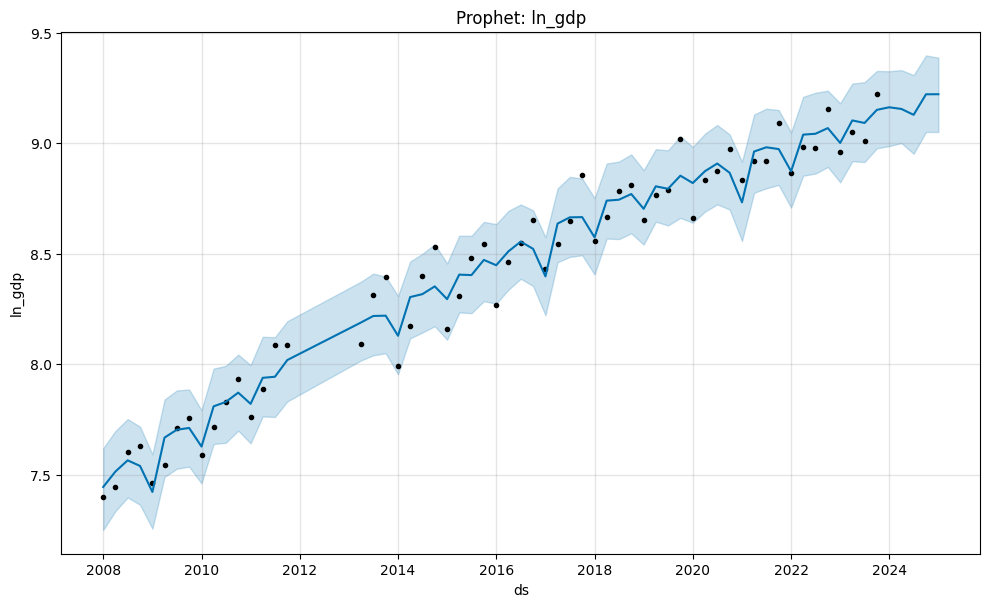

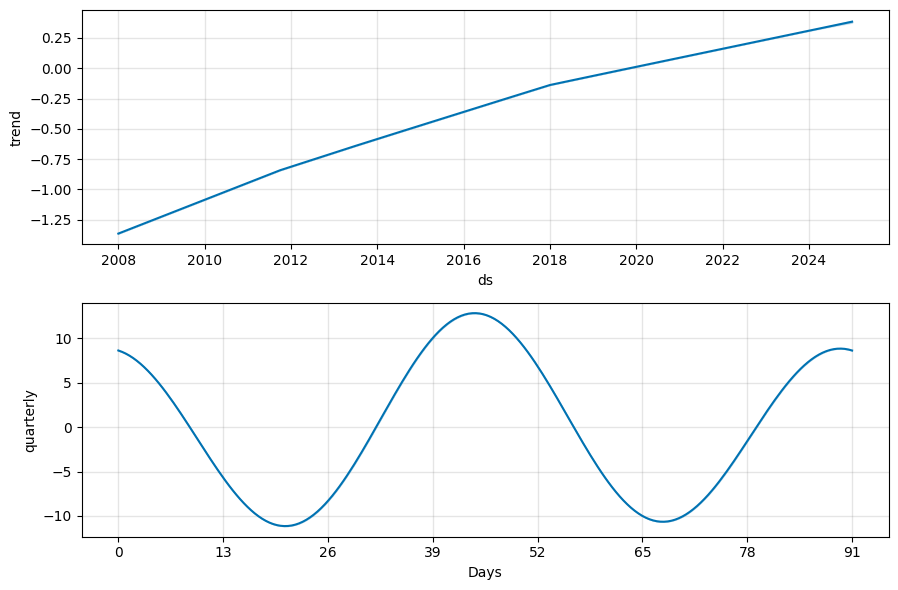

Prophet模型拟合完成！
训练数据期间: 2008-01-01 00:00:00 到 2023-10-01 00:00:00
训练数据量: 59


In [21]:
# Prophet模型拟合ln_gdp
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# 准备Prophet数据格式
prophet_data = df[['time', 'ln_gdp']].copy()
prophet_data.columns = ['ds', 'y']  # Prophet要求列名为ds(时间)和y(目标变量)
prophet_data = prophet_data.dropna()

# 创建Prophet模型 - 适合季度数据
model = Prophet(
    yearly_seasonality=False,   # 关闭默认年度季节性(会产生连续波动)
    weekly_seasonality=False,   # 关闭周季节性(季度数据不需要)
    daily_seasonality=False,    # 关闭日季节性(季度数据不需要)
    seasonality_mode='additive',  # 加法季节性
    interval_width=0.95  # 95%置信区间
)

# 添加季度季节性 - 针对季度数据优化
model.add_seasonality(
    name='quarterly', 
    period=365.25/4,  # 一个季度的天数
    fourier_order=2   # 减少傅里叶项，避免过度平滑
)

# 拟合模型
model.fit(prophet_data)

# 创建未来时间点用于预测
future = model.make_future_dataframe(periods=5, freq='Q')  # 预测未来5个季度
forecast = model.predict(future)

# 可视化结果
fig1 = model.plot(forecast)
plt.title('Prophet: ln_gdp')
plt.ylabel('ln_gdp')
plt.show()

# 组件分解图
fig2 = model.plot_components(forecast)
plt.show()

print("Prophet模型拟合完成！")
print(f"训练数据期间: {prophet_data['ds'].min()} 到 {prophet_data['ds'].max()}")
print(f"训练数据量: {len(prophet_data)}")

In [12]:
import pickle
import os
save_dir = r"D:\S_data\models"
os.makedirs(save_dir, exist_ok=True)
with open(os.path.join(save_dir, 'prophet.pkl'), 'wb') as f: pickle.dump(model, f)

Prophet置信区间计算方法
1. 基本原理
Prophet使用**模拟方法（Simulation）**来生成置信区间，而不是传统的解析方法。

2. 具体步骤
第一步：趋势不确定性

Prophet对趋势参数进行贝叶斯推断
从趋势参数的后验分布中抽样
默认使用Laplace近似来估计参数的不确定性
第二步：季节性不确定性

对季节性成分的傅里叶系数进行抽样
季节性参数通常假设为正态分布
第三步：噪声不确定性

从历史残差中进行bootstrap抽样
或者基于观测噪声的标准差进行抽样
第四步：蒙特卡洛模拟
默认1000次模拟


我用的线性函数拟合趋势，分段的

g(t)=C/1+exp(-K(t-m)) //
逻辑斯蒂增长曲线，K= 增长率，m= 拐点，C为曲线渐近线

分段逻辑斯蒂增长曲线--多拐点，渐近线和拐点由数据自动拟合

这是因为傅里叶级数的数学原理。让我解释一下：

## 傅里叶级数基础

**傅里叶级数的基本形式**：
任何周期函数都可以表示为正弦和余弦函数的无穷级数：



In [ ]:
f(t) = a₀ + Σ[aₙ·cos(nωt) + bₙ·sin(nωt)]



其中：
- `ω = 2π/T`（T是周期）
- `n = 1, 2, 3, ...`（谐波次数）

## Prophet中的fourier_order

**`fourier_order=2`的具体含义**：

当设置`fourier_order=2`时，Prophet会创建以下项：

1. **第1对**（n=1）：
   - `cos(1·ωt)` = `cos(2πt/T)`
   - `sin(1·ωt)` = `sin(2πt/T)`

2. **第2对**（n=2）：
   - `cos(2·ωt)` = `cos(4πt/T)`  
   - `sin(2·ωt)` = `sin(4πt/T)`

所以总共有**4个基函数**（2对正弦+余弦）。

## 为什么是"对"

**正弦和余弦是成对出现的**，因为：

1. **相位差**：正弦和余弦函数相位差90°，可以表示任意相位的周期信号
2. **完备性**：每个频率需要两个参数（幅度和相位），用一对sin/cos函数来表示
3. **灵活性**：`a·cos(ωt) + b·sin(ωt)`可以表示为`R·cos(ωt + φ)`的任意幅度R和相位φ

## 实际应用到季度数据

对于您的季度季节性（`period=365.25/4`）：
- **基本周期**：91.3天
- **第1对**：捕捉基本的季度周期性
- **第2对**：捕捉2倍频率的细节变化（约45.6天的模式）

这样Prophet可以用这4个参数来拟合复杂的季度季节性模式，既能捕捉主要的季度变化，又能处理季度内的细微波动。

**简单来说**：`fourier_order=n`就是用前n个频率的正弦余弦对来近似您的季节性模式，频率越高，能捕捉的细节越多，但也越容易过拟合。

In [23]:
# 保存数据集df为CSV格式到模型目录
import os

save_dir = r"D:\S_data\models"
os.makedirs(save_dir, exist_ok=True)

# 保存df数据集为CSV，命名为df_plus
csv_path = os.path.join(save_dir, 'df_plus.csv')
df.to_csv(csv_path, index=False, encoding='utf-8-sig')

In [20]:
# Prophet模型滚动窗口预测评估
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 准备Prophet数据格式
prophet_data = df[['time', 'ln_gdp']].copy()
prophet_data.columns = ['ds', 'y']  # Prophet要求列名为ds(时间)和y(目标变量)
prophet_data = prophet_data.dropna()

def rolling_prophet_prediction(data, window=40, steps=5):
    """Prophet模型滚动窗口预测"""
    mse_list = []
    predictions_all = []
    actuals_all = []
    
    # 滚动窗口预测
    for i in range(window, len(data) - steps + 1):
        try:
            # 训练数据
            train_data = data.iloc[i-window:i].copy()
            test_data = data.iloc[i:i+steps].copy()
            
            # 创建Prophet模型
            model_rolling = Prophet(
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode='additive'
            )
            model_rolling.add_seasonality(name='quarterly', period=365.25/4, fourier_order=2)
            
            # 拟合和预测
            model_rolling.fit(train_data)
            future = model_rolling.make_future_dataframe(periods=steps, freq='Q')
            forecast = model_rolling.predict(future)
            
            # 计算MSE
            pred_values = forecast['yhat'].iloc[-steps:].values
            actual_values = test_data['y'].values
            window_mse = mean_squared_error(actual_values, pred_values)
            mse_list.append(window_mse)
            
            predictions_all.extend(pred_values)
            actuals_all.extend(actual_values)
        except:
            continue
    
    avg_mse = np.mean(mse_list) if mse_list else float('inf')
    overall_mse = mean_squared_error(actuals_all, predictions_all) if actuals_all else float('inf')
    return mse_list, avg_mse, overall_mse

# 执行Prophet滚动窗口评估
mse_list, avg_mse, overall_mse = rolling_prophet_prediction(prophet_data, window=40, steps=5)

print(f"成功预测窗口数: {len(mse_list)}")
print(f"所有预测的整体MSE: {overall_mse:.6f}")
print(f"MSE最小值: {np.min(mse_list):.6f}")
print(f"MSE最大值: {np.max(mse_list):.6f}")



22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1]

成功预测窗口数: 15
所有预测的整体MSE: 0.012662
MSE最小值: 0.001654
MSE最大值: 0.026131
